In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import glob
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import netCDF4 as nc
import numpy as np
import scipy.stats as st
import xarray as xr
import xesmf as xe
import xgcm
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from palettable.colorbrewer.diverging import RdBu_11_r as rdbu_cm

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

figdir = '/home/561/jn8053/g_e14/figures-tmp/'

clnt = dsk.Client()
clnt

<Client: 'tcp://127.0.0.1:43111' processes=4 threads=16, memory=250.00 GiB>

In [23]:
# Font size
plt.rcParams['font.size'] = 16
# Axes
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
# Saving parameters
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

def change_lon_space(ds, grid):
    if grid == 'u':
        ds = ds.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < 0, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    elif grid == 't':
        ds = ds.rename(({'xt_ocean':'lon', 'yt_ocean':'lat'}))
        ds['_lon_adj'] = xr.where(ds['lon'] < 0, ds['lon'] + 360, ds['lon'])
        ds = ds.swap_dims({'lon': '_lon_adj'})
        ds = ds.sel(**{'_lon_adj': sorted(ds._lon_adj)}).drop('lon')
        ds = ds.rename({'_lon_adj': 'lon'})
    return ds

def figure_along_slope():
    
    fig, axs = plt.subplots(figsize = (15, 5))
    axs.set_ylim(-80, -60);
    axs.set_xticks(np.arange(0, 400, 50))
    axs.set_xlim(0, 360)
    axs.set_yticks(np.arange(-80, -55, 5))
    axs.set_xlabel('Longitude')
    axs.set_ylabel('Latitude')
    
    return fig, axs

def southern_ocean(ds):
    ds_so = ds.sel(yt_ocean = slice(None, -60)).squeeze()
    return ds_so

def southern_ocean_surface(ds):
    ds_so = ds.sel(yt_ocean = slice(None, -60)).isel(st_ocean = 0).squeeze()
    return ds_so

def southern_ocean_bottom(ds):
    depth_array = ds_cr['temp'] * 0 + ds_cr['temp']['st_ocean']
    max_depth = depth_array.max(dim = 'st_ocean', skipna = True)
    ds_so = ds.sel(yt_ocean = slice(None, -60)).where(depth_array.st_ocean >= max_depth).squeeze()
    return ds_so

shelfmsk = xr.open_dataset('/scratch/e14/jn8053/misc/Antarctic_slope_mask.nc')['__xarray_dataarray_variable__']
distance = xr.open_dataset('~/g_e14/Antarctic_distance_along_1000.nc')

# Reference fig

In [26]:
ticks = np.arange(0, 22.5, 2.5)
np.where(distance['distance']==ticks)

ValueError: shape mismatch: objects cannot be broadcast to a single shape

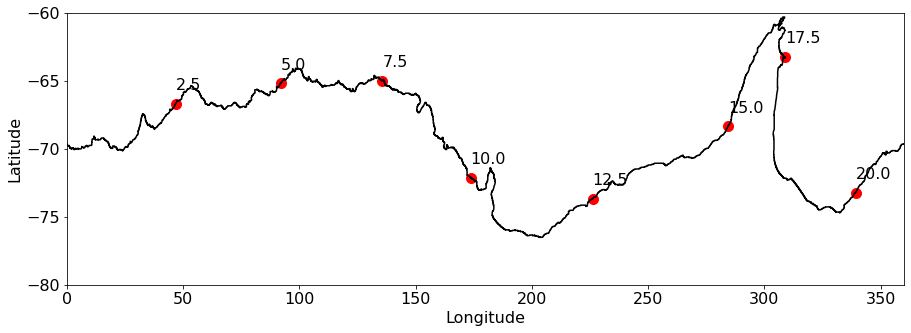

In [43]:
fig, axs = figure_along_slope()
axs.plot(distance['lon'], distance['lat'], distance['distance'], color = 'k')
ticks = np.arange(2.5, 22.5, 2.5)
for t in ticks:
    loc = np.where(np.abs(distance['distance']-t) == np.min(np.abs(distance['distance']-t)))[0]
    axs.scatter(distance['lon'][loc[0]], distance['lat'][loc[0]], s = 100, marker = 'o', color = 'r')
    axs.text(distance['lon'][loc[0]], distance['lat'][loc[0]]+1, str(t))
plt.savefig(figdir+'easterlies-collaborative/distance-along-isobath-reference.png')

# SST

In [5]:
files_ryf = [f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output{n}/ocean/ocean_month.nc" for n in np.arange(996, 1056, 1)]
files_easup = [f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_easterlies_up10/output{n}/ocean/ocean_month.nc" for n in np.arange(996, 1056, 1)]
files_easdo = [f"/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091_easterlies_down10//output{n}/ocean/ocean_month.nc" for n in np.arange(996, 1056, 1)]

example = xr.open_dataset(files_ryf[0])
drop = [i for i in example.variables]
drop.remove('surface_temp')
drop.remove('surface_salt')
drop.remove('xt_ocean')
drop.remove('yt_ocean')
drop.remove('time')

ds_ct = xr.open_mfdataset(files_ryf, parallel = True, preprocess = southern_ocean, concat_dim = 'time', drop_variables = drop)
ds_up = xr.open_mfdataset(files_easup, parallel = True, preprocess = southern_ocean, concat_dim = 'time', drop_variables = drop)
ds_do = xr.open_mfdataset(files_easdo, parallel = True, preprocess = southern_ocean, concat_dim = 'time', drop_variables = drop)

ds_ct = change_lon_space(ds_ct, 't')
ds_up = change_lon_space(ds_up, 't')
ds_do = change_lon_space(ds_do, 't')

In [14]:
sst = {}
sst_slope = {}
sst['ctrl'] = ds_ct['surface_temp'].load()
sst['up'] = ds_up['surface_temp'].load()
sst['down'] = ds_do['surface_temp'].load()
N = 6002
sst_slope['ctrl'] = np.empty([180, N])
sst_slope['up'] = np.empty([180, N])
sst_slope['down'] = np.empty([180, N])
for i in range(N):
    xx = distance['lon'][i]
    yy = distance['lat'][i]
    sst_slope['ctrl'][:, i] = sst['ctrl'].sel(lon = slice(xx-0.5, xx+0.5), lat = slice(yy-0.5, yy+0.5)).mean(['lon', 'lat']).values
    sst_slope['up'][:, i] = sst['up'].sel(lon = slice(xx-0.5, xx+0.5), lat = slice(yy-0.5, yy+0.5)).mean(['lon', 'lat']).values
    sst_slope['down'][:, i] = sst['down'].sel(lon = slice(xx-0.5, xx+0.5), lat = slice(yy-0.5, yy+0.5)).mean(['lon', 'lat']).values

sst_slope['ctrl'] = xr.DataArray(sst_slope['ctrl'], dims = ['time', 'distance'], coords = {'time':ds_ct['time'], 'distance':distance['distance']})
sst_slope['up'] = xr.DataArray(sst_slope['up'], dims = ['time', 'distance'], coords = {'time':ds_ct['time'], 'distance':distance['distance']})
sst_slope['down'] = xr.DataArray(sst_slope['down'], dims = ['time', 'distance'], coords = {'time':ds_ct['time'], 'distance':distance['distance']})

sst_slope_a = {}
for k in ['ctrl', 'up', 'down']:
    sst_slope_a[k] = sst_slope[k].groupby('time.month') - sst_slope[k].groupby('time.month').mean('time')

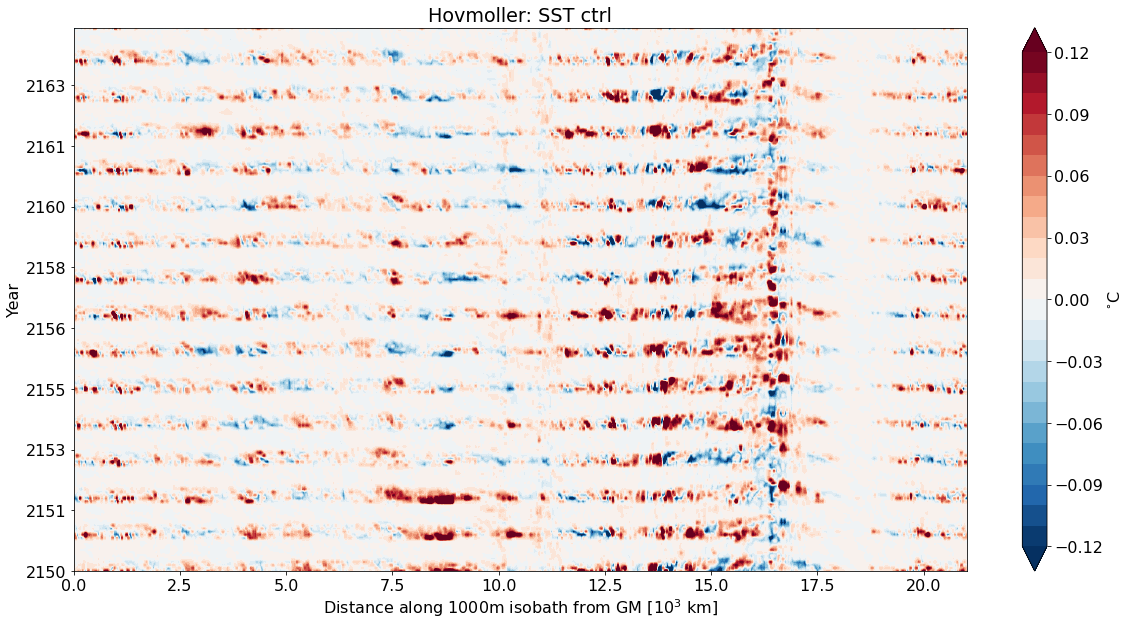

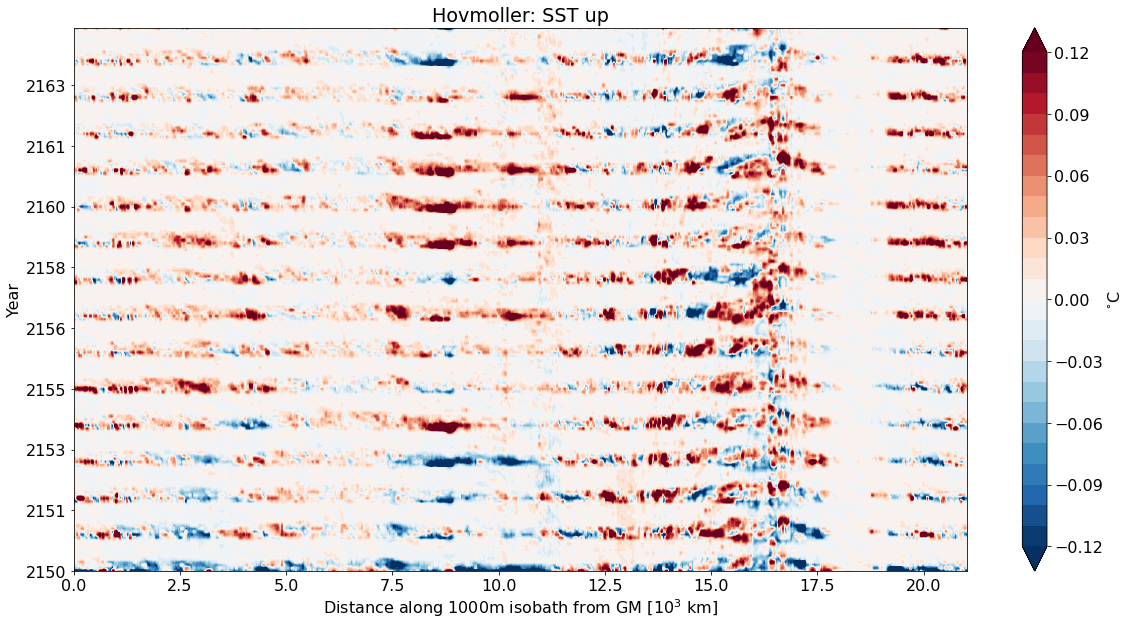

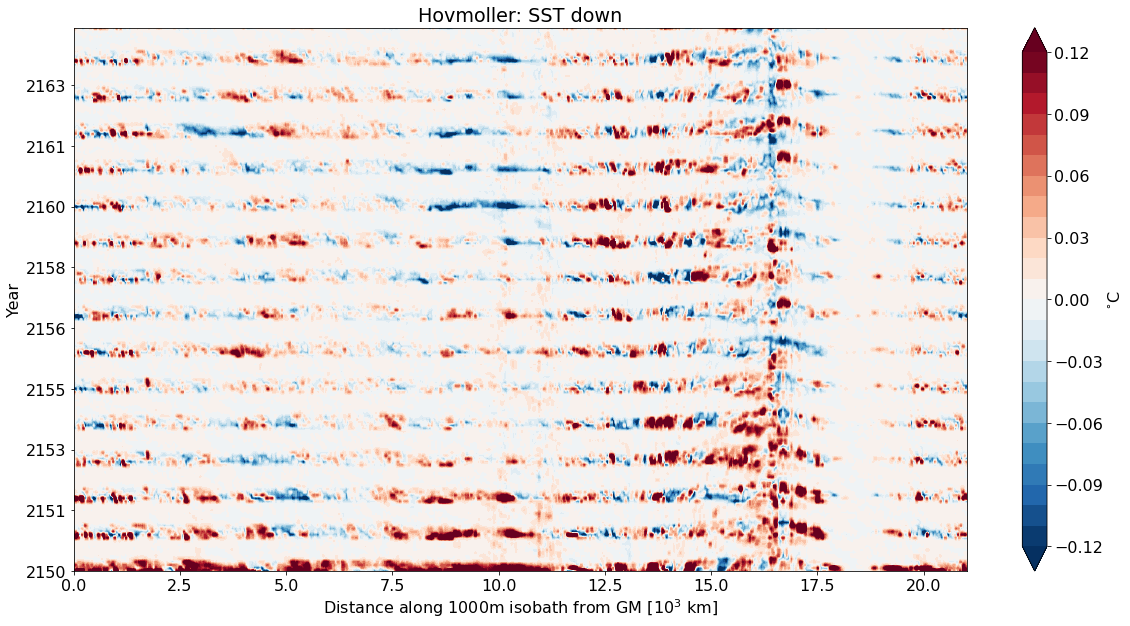

In [54]:
for k in ['ctrl', 'up', 'down']:
    plt.figure(figsize = (20, 10))
    plt.contourf(sst_slope[k]['distance'], np.arange(0, 180, 1), sst_slope_a[k], 
                 np.arange(-.12, .13, .01), cmap = rdbu_cm.mpl_colormap, extend = 'both')
    plt.yticks(np.arange(0, 180, 20), sst_slope[k]['time.year'].values[::20])
    plt.ylabel('Year')
    plt.xlabel('Distance along 1000m isobath from GM [10$^3$ km]')
    plt.title('Hovmoller: SST '+k)
    plt.colorbar().set_label('$^{\circ}$C')
    plt.savefig(figdir+'easterlies-collaborative/sst-hovmoller-'+k+'.png')

In [20]:
sss = {}
sss_slope = {}
sss['ctrl'] = ds_ct['surface_salt'].load()
sss['up'] = ds_up['surface_salt'].load()
sss['down'] = ds_do['surface_salt'].load()
N = 6002
sss_slope['ctrl'] = np.empty([180, N])
sss_slope['up'] = np.empty([180, N])
sss_slope['down'] = np.empty([180, N])
for i in range(N):
    xx = distance['lon'][i]
    yy = distance['lat'][i]
    sss_slope['ctrl'][:, i] = sss['ctrl'].sel(lon = slice(xx-0.5, xx+0.5), lat = slice(yy-0.5, yy+0.5)).mean(['lon', 'lat']).values
    sss_slope['up'][:, i] = sss['up'].sel(lon = slice(xx-0.5, xx+0.5), lat = slice(yy-0.5, yy+0.5)).mean(['lon', 'lat']).values
    sss_slope['down'][:, i] = sss['down'].sel(lon = slice(xx-0.5, xx+0.5), lat = slice(yy-0.5, yy+0.5)).mean(['lon', 'lat']).values

sss_slope['ctrl'] = xr.DataArray(sss_slope['ctrl'], dims = ['time', 'distance'], coords = {'time':ds_ct['time'], 'distance':distance['distance']})
sss_slope['up'] = xr.DataArray(sss_slope['up'], dims = ['time', 'distance'], coords = {'time':ds_ct['time'], 'distance':distance['distance']})
sss_slope['down'] = xr.DataArray(sss_slope['down'], dims = ['time', 'distance'], coords = {'time':ds_ct['time'], 'distance':distance['distance']})

sss_slope_a = {}
for k in ['ctrl', 'up', 'down']:
    sss_slope_a[k] = sss_slope[k].groupby('time.month') - sss_slope[k].groupby('time.month').mean('time')

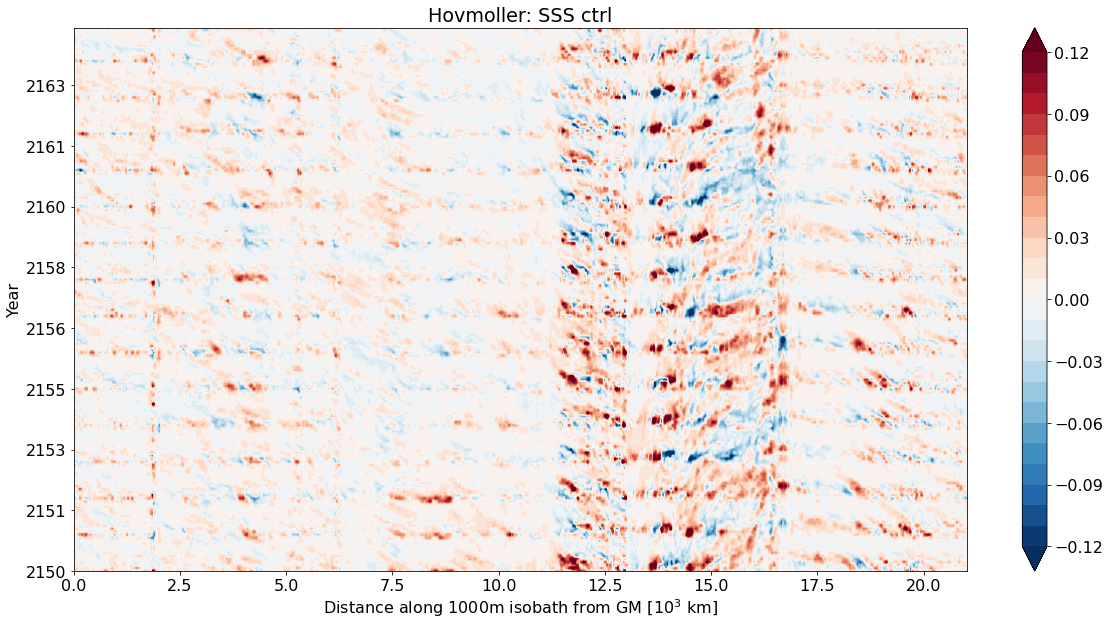

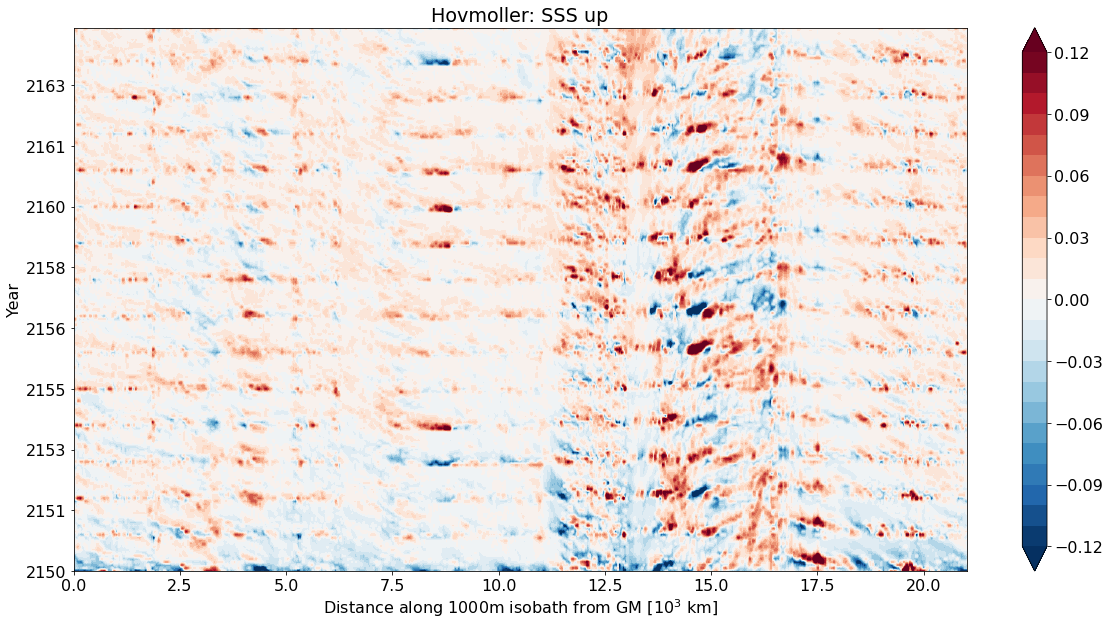

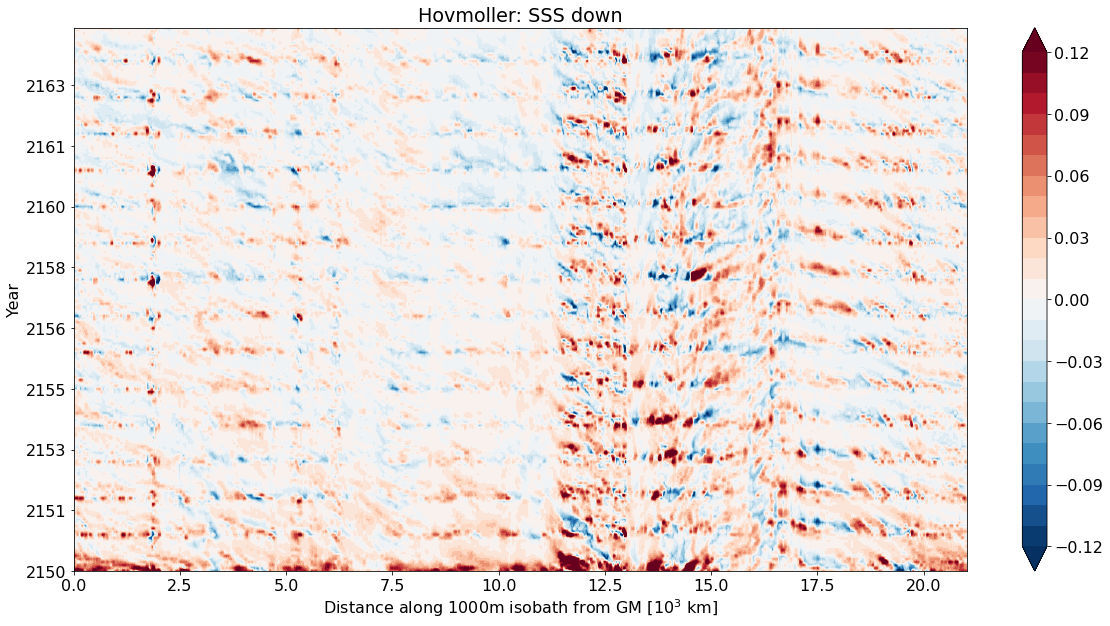

In [55]:
for k in ['ctrl', 'up', 'down']:
    plt.figure(figsize = (20, 10))
    plt.contourf(sss_slope[k]['distance'], np.arange(0, 180, 1), sss_slope_a[k], 
                 np.arange(-.12, .13, .01), cmap = rdbu_cm.mpl_colormap, extend = 'both')
    plt.yticks(np.arange(0, 180, 20), sst_slope[k]['time.year'].values[::20])
    plt.ylabel('Year')
    plt.xlabel('Distance along 1000m isobath from GM [10$^3$ km]')
    plt.title('Hovmoller: SSS '+k)
    plt.colorbar()
    plt.savefig(figdir+'easterlies-collaborative/sss-hovmoller-'+k+'.png')

# Bottom temp and salt

In [19]:
import cosima_cookbook as cc

session_ctrl = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
exp_ctrl = '01deg_jra55v13_ryf9091'
session_east = cc.database.create_session('/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db')
exp_easu = '01deg_jra55v13_ryf9091_easterlies_up10'
exp_easd = '01deg_jra55v13_ryf9091_easterlies_down10'
ti = '2150-01-01'
tf = '2164-12-31'
lat_slice  = slice(-80, -59)

In [4]:
# Only run once
temp_con = cc.querying.getvar(exp_ctrl, 'temp', session_ctrl, frequency = '1 monthly', start_time = ti, end_time = tf) - 273.15
temp_con = temp_con.sel(yt_ocean = lat_slice).sel(time = slice(ti, tf))
temp_up = cc.querying.getvar(exp_easu, 'temp', session_east, frequency = '1 monthly', start_time = ti, end_time = tf) - 273.15
temp_up = temp_up.sel(yt_ocean = lat_slice).sel(time = slice(ti, tf))
temp_down = cc.querying.getvar(exp_easd, 'temp', session_east, frequency = '1 monthly', start_time = ti, end_time = tf) - 273.15
temp_down = temp_down.sel(yt_ocean = lat_slice).sel(time = slice(ti, tf))

depth_array = temp_down * 0 + temp_down['st_ocean']
max_depth = depth_array.max(dim = 'st_ocean', skipna = True)

temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
temp_con = temp_con.sum('st_ocean')
temp_con.to_netcdf('../data/bottom_temp-control.nc')
temp_up = temp_up.where(depth_array.st_ocean >= max_depth)
temp_up = temp_up.sum('st_ocean')
temp_up.to_netcdf('../data/bottom_temp-up.nc')
temp_down = temp_down.where(depth_array.st_ocean >= max_depth)
temp_down = temp_down.sum('st_ocean')
temp_down.to_netcdf('../data/bottom_temp-down.nc')

btemp = {}
btemp['ctrl'] = xr.open_dataset('../data/bottom_temp-control.nc')['temp']
btemp['up'] = xr.open_dataset('../data/bottom_temp-up.nc')['temp']
btemp['down'] = xr.open_dataset('../data/bottom_temp-down.nc')['temp']
btemp['ctrl'] = change_lon_space(btemp['ctrl'], 't')
btemp['up'] = change_lon_space(btemp['up'], 't')
btemp['down'] = change_lon_space(btemp['down'], 't')
btemp_slope = {}
N = 6002
btemp_slope['ctrl'] = np.empty([180, N])
btemp_slope['up'] = np.empty([180, N])
btemp_slope['down'] = np.empty([180, N])
for i in range(N):
    xx = distance['lon'][i]
    yy = distance['lat'][i]
    btemp_slope['ctrl'][:, i] = btemp['ctrl'].sel(lon = slice(xx-0.5, xx+0.5), lat = slice(yy-0.5, yy+0.5)).mean(['lon', 'lat']).values
    btemp_slope['up'][:, i] = btemp['up'].sel(lon = slice(xx-0.5, xx+0.5), lat = slice(yy-0.5, yy+0.5)).mean(['lon', 'lat']).values
    btemp_slope['down'][:, i] = btemp['down'].sel(lon = slice(xx-0.5, xx+0.5), lat = slice(yy-0.5, yy+0.5)).mean(['lon', 'lat']).values

btemp_slope['ctrl'] = xr.DataArray(btemp_slope['ctrl'], dims = ['time', 'distance'], coords = {'time':btemp['ctrl']['time'], 'distance':distance['distance']})
btemp_slope['up'] = xr.DataArray(btemp_slope['up'], dims = ['time', 'distance'], coords = {'time':btemp['up']['time'], 'distance':distance['distance']})
btemp_slope['down'] = xr.DataArray(btemp_slope['down'], dims = ['time', 'distance'], coords = {'time':btemp['down']['time'], 'distance':distance['distance']})

for k in ['ctrl', 'up', 'down']:
    btemp_slope[k].to_netcdf('../data/bottom_temp_along_slope-'+k+'.nc')

In [15]:
btemp_slope = {}
btemp_slope_a = {}
for k in ['ctrl', 'up', 'down']:
    btemp_slope[k] = xr.open_dataset('../data/bottom_temp_along_slope-'+k+'.nc')['__xarray_dataarray_variable__']
    btemp_slope_a[k] = btemp_slope[k].groupby('time.month') - btemp_slope[k].groupby('time.month').mean('time')

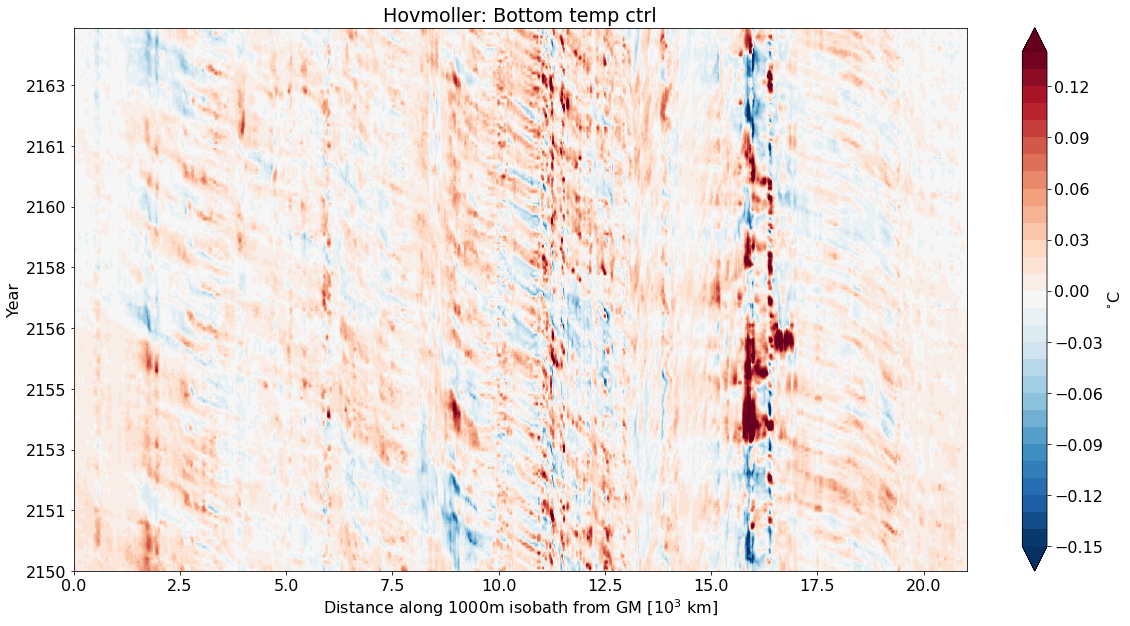

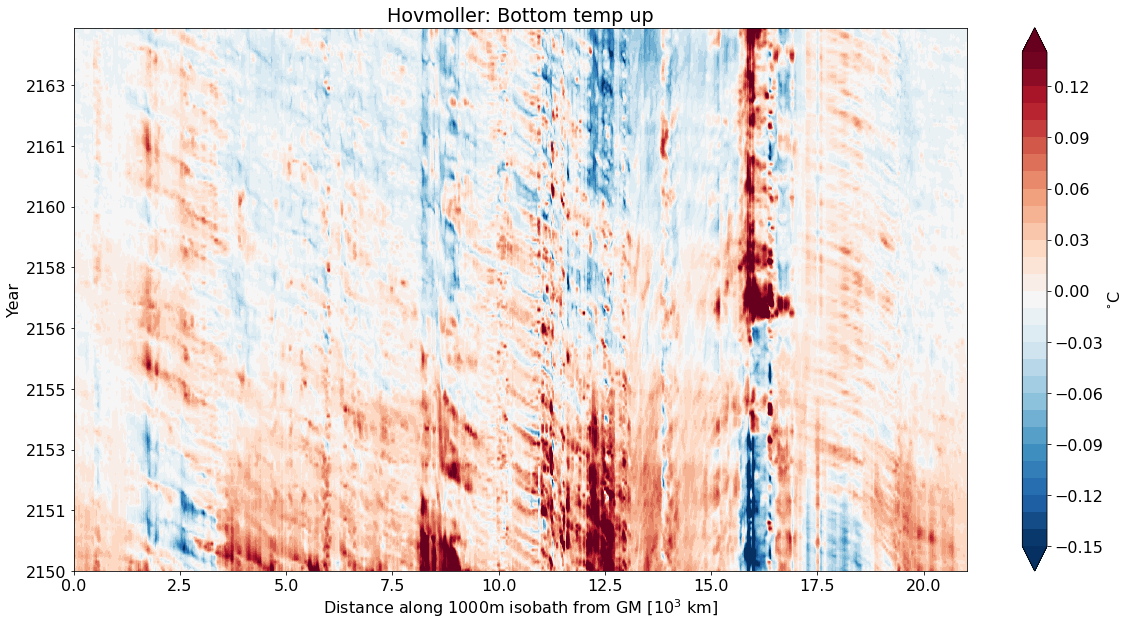

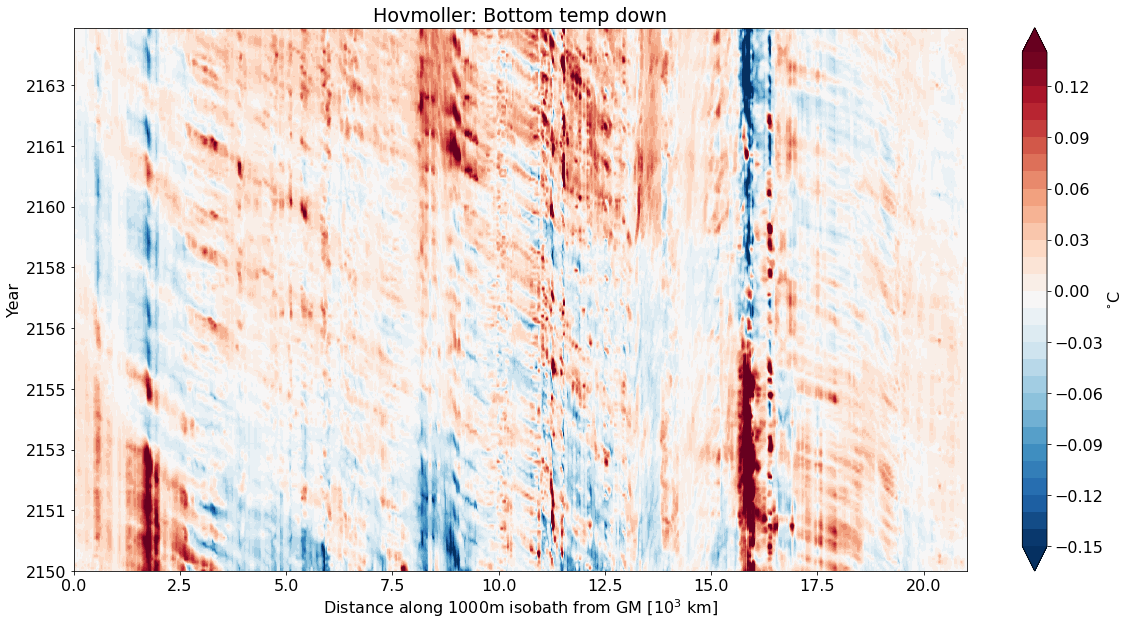

In [17]:
for k in ['ctrl', 'up', 'down']:
    plt.figure(figsize = (20, 10))
    plt.contourf(btemp_slope_a[k]['distance'], np.arange(0, 180, 1), btemp_slope_a[k], 
                 np.arange(-.15, .15, .01), cmap = rdbu_cm.mpl_colormap, extend = 'both')
    plt.yticks(np.arange(0, 180, 20), btemp_slope[k]['time.year'].values[::20])
    plt.ylabel('Year')
    plt.xlabel('Distance along 1000m isobath from GM [10$^3$ km]')
    plt.title('Hovmoller: Bottom temp '+k)
    plt.colorbar().set_label('$^{\circ}$C')
    plt.savefig(figdir+'easterlies-collaborative/btemp-hovmoller-'+k+'.png')

In [20]:
# Only run once
salt_con = cc.querying.getvar(exp_ctrl, 'salt', session_ctrl, frequency = '1 monthly', start_time = ti, end_time = tf)
salt_con = salt_con.sel(yt_ocean = lat_slice).sel(time = slice(ti, tf))
salt_up = cc.querying.getvar(exp_easu, 'salt', session_east, frequency = '1 monthly', start_time = ti, end_time = tf)
salt_up = salt_up.sel(yt_ocean = lat_slice).sel(time = slice(ti, tf))
salt_down = cc.querying.getvar(exp_easd, 'salt', session_east, frequency = '1 monthly', start_time = ti, end_time = tf)
salt_down = salt_down.sel(yt_ocean = lat_slice).sel(time = slice(ti, tf))

depth_array = salt_down * 0 + salt_down['st_ocean']
max_depth = depth_array.max(dim = 'st_ocean', skipna = True)

salt_con = salt_con.where(depth_array.st_ocean >= max_depth)
salt_con = salt_con.sum('st_ocean')
salt_con.to_netcdf('../data/bottom_salt-ctrl.nc')
salt_up = salt_up.where(depth_array.st_ocean >= max_depth)
salt_up = salt_up.sum('st_ocean')
salt_up.to_netcdf('../data/bottom_salt-up.nc')
salt_down = salt_down.where(depth_array.st_ocean >= max_depth)
salt_down = salt_down.sum('st_ocean')
salt_down.to_netcdf('../data/bottom_salt-down.nc')

bsalt = {}
bsalt['ctrl'] = xr.open_dataset('../data/bottom_salt-ctrl.nc')['salt']
bsalt['up'] = xr.open_dataset('../data/bottom_salt-up.nc')['salt']
bsalt['down'] = xr.open_dataset('../data/bottom_salt-down.nc')['salt']
bsalt['ctrl'] = change_lon_space(bsalt['ctrl'], 't')
bsalt['up'] = change_lon_space(bsalt['up'], 't')
bsalt['down'] = change_lon_space(bsalt['down'], 't')
bsalt_slope = {}
N = 6002
bsalt_slope['ctrl'] = np.empty([180, N])
bsalt_slope['up'] = np.empty([180, N])
bsalt_slope['down'] = np.empty([180, N])
for i in range(N):
    xx = distance['lon'][i]
    yy = distance['lat'][i]
    bsalt_slope['ctrl'][:, i] = bsalt['ctrl'].sel(lon = slice(xx-0.5, xx+0.5), lat = slice(yy-0.5, yy+0.5)).mean(['lon', 'lat']).values
    bsalt_slope['up'][:, i] = bsalt['up'].sel(lon = slice(xx-0.5, xx+0.5), lat = slice(yy-0.5, yy+0.5)).mean(['lon', 'lat']).values
    bsalt_slope['down'][:, i] = bsalt['down'].sel(lon = slice(xx-0.5, xx+0.5), lat = slice(yy-0.5, yy+0.5)).mean(['lon', 'lat']).values

bsalt_slope['ctrl'] = xr.DataArray(bsalt_slope['ctrl'], dims = ['time', 'distance'], coords = {'time':bsalt['ctrl']['time'], 'distance':distance['distance']})
bsalt_slope['up'] = xr.DataArray(bsalt_slope['up'], dims = ['time', 'distance'], coords = {'time':bsalt['up']['time'], 'distance':distance['distance']})
bsalt_slope['down'] = xr.DataArray(bsalt_slope['down'], dims = ['time', 'distance'], coords = {'time':bsalt['down']['time'], 'distance':distance['distance']})

for k in ['ctrl', 'up', 'down']:
    bsalt_slope[k].to_netcdf('../data/bottom_salt_along_slope-'+k+'.nc')

In [4]:
bsalt_slope = {}
bsalt_slope_a = {}
for k in ['ctrl', 'up', 'down']:
    bsalt_slope[k] = xr.open_dataset('../data/bottom_salt_along_slope-'+k+'.nc')['__xarray_dataarray_variable__']
    bsalt_slope_a[k] = bsalt_slope[k].groupby('time.month') - bsalt_slope[k].groupby('time.month').mean('time')

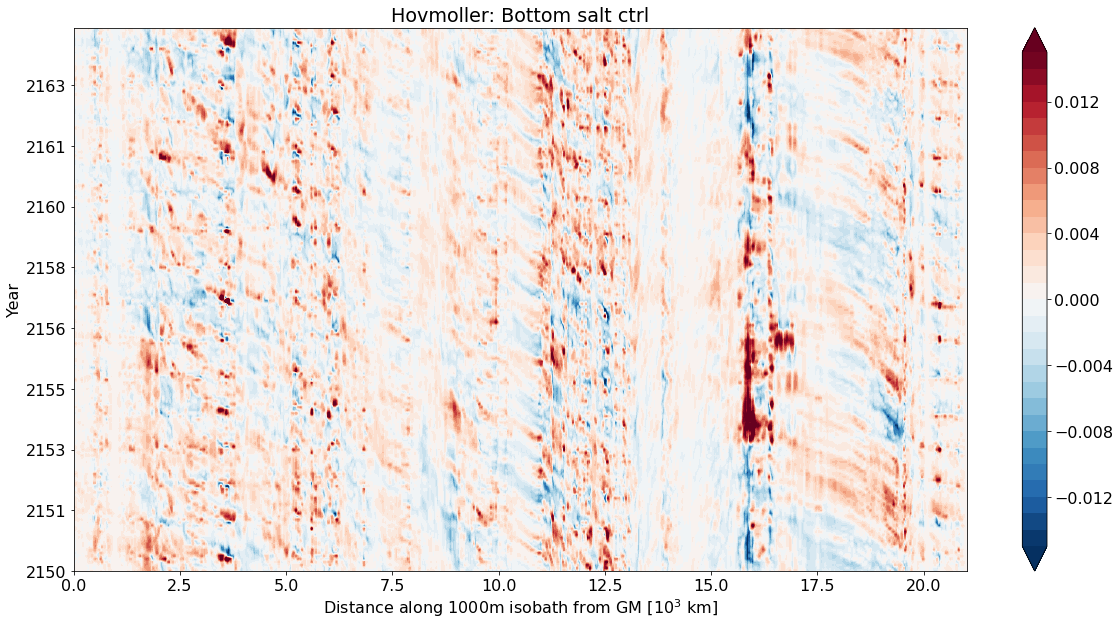

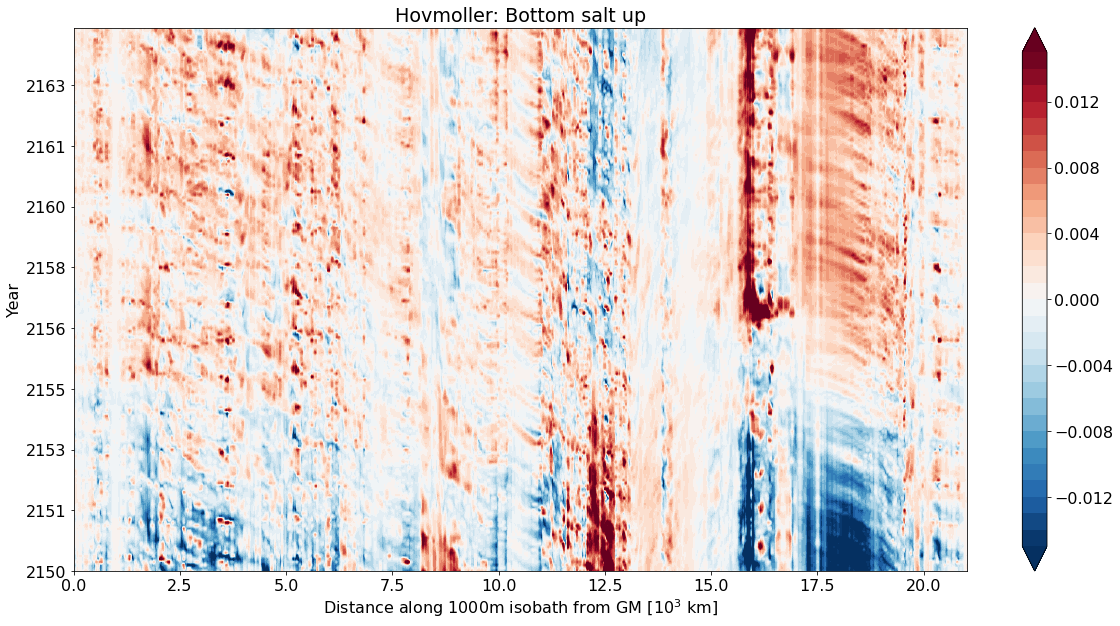

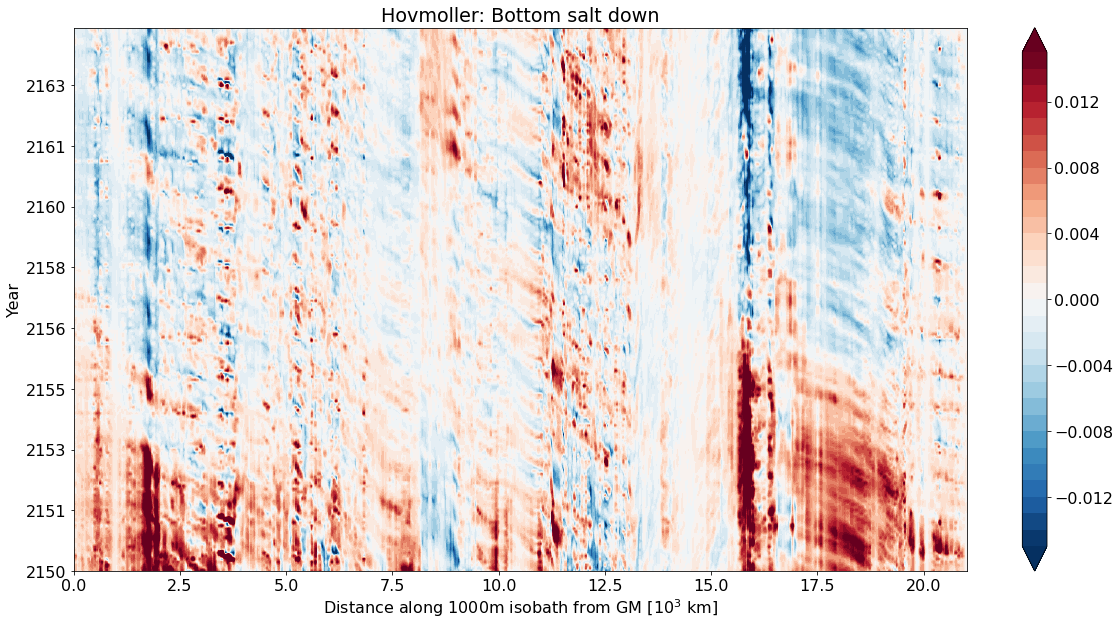

In [7]:
for k in ['ctrl', 'up', 'down']:
    plt.figure(figsize = (20, 10))
    plt.contourf(bsalt_slope_a[k]['distance'], np.arange(0, 180, 1), bsalt_slope_a[k], 
                 np.arange(-.015, .016, .001), cmap = rdbu_cm.mpl_colormap, extend = 'both')
    plt.yticks(np.arange(0, 180, 20), bsalt_slope[k]['time.year'].values[::20])
    plt.ylabel('Year')
    plt.xlabel('Distance along 1000m isobath from GM [10$^3$ km]')
    plt.title('Hovmoller: Bottom salt '+k)
    plt.colorbar()
    plt.savefig(figdir+'easterlies-collaborative/bsalt-hovmoller-'+k+'.png')